# ORFit for RMNIST

# 0. Imports

In [3]:
from typing import Callable

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import seaborn as sns
import flax.linen as nn
from jax import jacrev, vmap, jit
import matplotlib.pyplot as plt
import pandas as pd

from dynamax.utils import datasets
from dynamax.rebayes.utils import MLP, get_mlp_flattened_params
from dynamax.rebayes.orfit import ORFitParams, RebayesORFit

/Users/peterchang/Desktop/Repos/dynamax/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def orfit_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

In [5]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 784, [100, 50, 10, 10,], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

# L2 loss
loss_fn = lambda w, x, y: (apply_fn(w, x) - y)**2

(84181,)


# 1. R-MNIST with Trenches

In [6]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

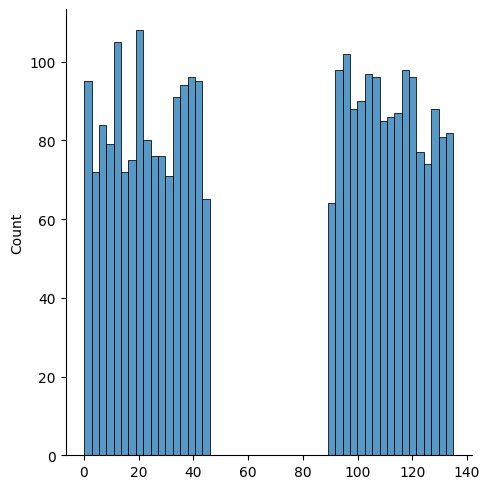

In [7]:
map_trench_1 = (y_train  >= 0) & (y_train <= 45)
map_trench_2 = (y_train >= 90) & (y_train <= 135)
map_trench = map_trench_1 | map_trench_2

y_eval = y_train[map_trench]
X_eval = X_train[map_trench]
sns.displot(y_eval, bins=50);

In [17]:
# Initialize orfit estimator
orfit_params = ORFitParams(
    initial_mean=flat_params,
    apply_function=apply_fn,
    loss_function=lambda w, x, y: (apply_fn(w, x) - y)**2,
    memory_size=len(X_eval),
)
estimator = RebayesORFit(orfit_params)

In [18]:
# Run Infinite-memory ORFit on the dataset
bel, _ = estimator.scan(X_eval, y_eval)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_test, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

In [28]:
metric_mae = jnp.abs(pred_mean - y_test).mean()
metric_mae

Array(31.174833, dtype=float32)

In [29]:
metric_rmse = jnp.sqrt(jnp.power(pred_mean - y_test, 2).mean())
metric_rmse

Array(43.69478, dtype=float32)

In [30]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)

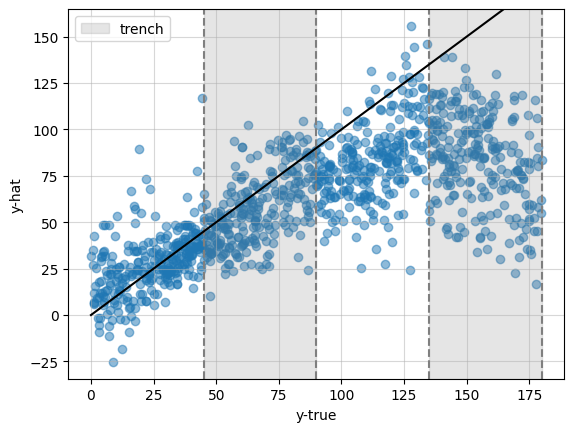

In [31]:
residual_err = pred_mean
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

In [32]:
n_rotations = 181
rotations = np.linspace(0, 180, n_rotations)

# group_ix = jnp.digitize(yhat_test, rotations)
group_ix = jnp.digitize(y_test, rotations)

summary_est = pd.DataFrame({
    "y_hat": np.array(pred_mean),
    "group": np.array(group_ix),
}).groupby("group").mean()


summary_est_std = pd.DataFrame({
    "y_hat_std": np.array(pred_mean),
    "group": np.array(group_ix),
}).groupby("group").std()


summary_true = pd.DataFrame({
    "y_true": np.array(y_test),
    "group": np.array(group_ix),
}).groupby("group").mean()

summary = summary_true.join(summary_est).join(summary_est_std)

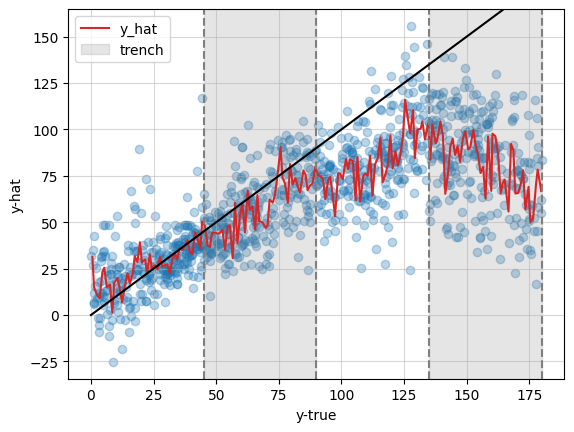

In [33]:
residual_err = pred_mean
fig, ax = plt.subplots()

summary.plot(x="y_true", y="y_hat", ax=ax, c="tab:red")

plt.scatter(y_test, residual_err, alpha=0.3, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

# 2. Multiple Passes

In [9]:
# 50 passes over the dataset
n_passes = 10
X_multiple_eval, y_multiple_eval = jnp.tile(X_eval, (n_passes, 1)), jnp.tile(y_eval, n_passes,)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_eval)))
X_multiple_eval, y_multiple_eval = X_multiple_eval[idx_perm], y_multiple_eval[idx_perm]

In [10]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator.scan(X_multiple_eval, y_multiple_eval)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_test, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 29,230 iterations: 100%|██████████| 29230/29230 [05:34<00:00, 87.46it/s]


In [11]:
metric_mae = jnp.abs(pred_mean - y_test).mean()
metric_mae

Array(2260.8723, dtype=float32)

In [12]:
metric_rmse = jnp.sqrt(jnp.power(pred_mean - y_test, 2).mean())
metric_rmse

Array(2701.4312, dtype=float32)

In [13]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)

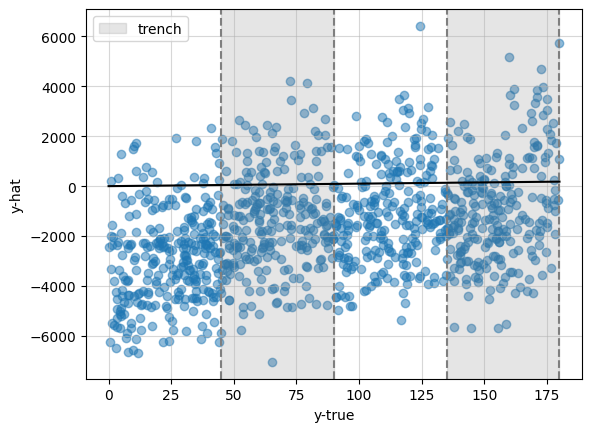

In [14]:
residual_err = pred_mean
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

In [15]:
n_rotations = 181
rotations = np.linspace(0, 180, n_rotations)

# group_ix = jnp.digitize(yhat_test, rotations)
group_ix = jnp.digitize(y_test, rotations)

summary_est = pd.DataFrame({
    "y_hat": np.array(pred_mean),
    "group": np.array(group_ix),
}).groupby("group").mean()


summary_est_std = pd.DataFrame({
    "y_hat_std": np.array(pred_mean),
    "group": np.array(group_ix),
}).groupby("group").std()


summary_true = pd.DataFrame({
    "y_true": np.array(y_test),
    "group": np.array(group_ix),
}).groupby("group").mean()

summary = summary_true.join(summary_est).join(summary_est_std)

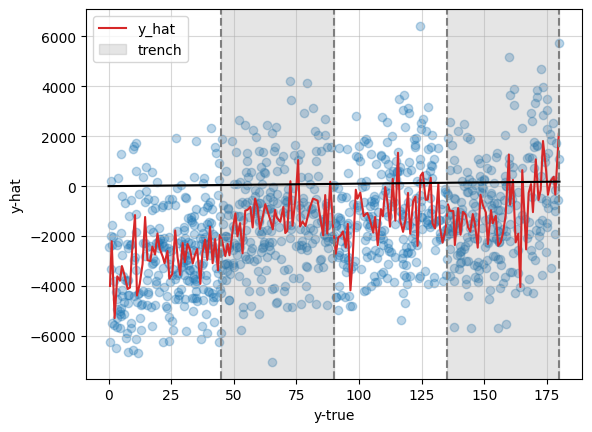

In [16]:
residual_err = pred_mean
fig, ax = plt.subplots()

summary.plot(x="y_true", y="y_hat", ax=ax, c="tab:red")

plt.scatter(y_test, residual_err, alpha=0.3, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)